# Mount google drive and import libraries

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import sys
#sys.path.append("/content/drive/MyDrive/sem2-project_1/treepedia_dl_public-master") # relative import doesn't work on colab, use code below instead
#import rep_results as treepedia_dl

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Check GPU status

In [ ]:
# check GPU status
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 21 14:13:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# check RAM size
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# chekc runtime improvement with GPU vs CPU
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# use random images and convolution to test runtime differences
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.47434543899999
GPU (s):
0.11863586099997292
GPU speedup over CPU: 71x


# load images

### GSV images

#### load, resize and save as np array

ignore steps in this session if the array has already been extracted. 

In [9]:
from PIL import Image

def load_and_resize(image_loc):
  '''
  load masked_img and masked_2channel into array and resize them. 
  '''
  current_model = [224, 224, 3]
  test_data = []
  test_gt = []
  with open(image_loc, 'r') as training:
      content = training.readlines()
  for line in content:
      paths = line.split()
      if len(paths) == 2:
          test_data.append(paths[0])
          test_gt.append(paths[1].replace("\n", ""))
      if len(paths) == 3:
          test_data.append(paths[0] + " "+paths[1])
          test_gt.append(paths[2].replace("\n", ""))
      if len(paths) == 1:
          test_data.append(paths[0])
  imgdata = []
  for path1 in test_data:
      imgdata.append(np.asarray((Image.open(path1).resize(current_model[0:2]))))
  labeldata = []
  for path in test_gt:
      labeldata.append(np.asarray((Image.open(path).resize(current_model[0:2]))))

  # convert list of arrays to arrays
  imgdata_array = np.zeros(
      [len(imgdata), current_model[0], current_model[1], current_model[2]], dtype=np.uint8)
  labeldata_array = np.zeros([len(imgdata), current_model[0], current_model[1]], dtype=np.uint8)
  for i in range(len(imgdata)):
      imgdata_array[i, :, :, :] = imgdata[i]
      labeldata_array[i, :, :] = labeldata[i]
  del (imgdata, labeldata)
  return (imgdata_array, labeldata_array)

In [10]:
X_train, y_train = load_and_resize(
    "/content/drive/MyDrive/sem2-project_1/images/mask/labelled_pairs_train2_xj.txt")
_valid, y_valid = load_and_resize(
    "/content/drive/MyDrive/sem2-project_1/images/mask/labelled_pairs_val2_xj.txt")
#X_test, y_test = load_and_resize(
#    "/content/drive/MyDrive/sem2-project_1/images/mask/labelled_pair_test.txt")


In [11]:
#print(X_train.shape, y_train.shape)
#print(X_valid.shape, y_valid.shape)
#print(X_test.shape, y_test.shape)

In [14]:
np.save("/content/drive/MyDrive/sem2-project_1/images/mask/X_train_DCNN.npy", X_train)
np.save("/content/drive/MyDrive/sem2-project_1/images/mask/y_train_DCNN.npy", y_train)

np.save("/content/drive/MyDrive/sem2-project_1/images/mask/X_valid_DCNN.npy", _valid)
np.save("/content/drive/MyDrive/sem2-project_1/images/mask/y_valid_DCNN.npy", y_valid)

#np.save("/content/drive/MyDrive/sem2-project_1/images/mask/X_test_DCNN.npy", X_test)
#np.save("/content/drive/MyDrive/sem2-project_1/images/mask/y_test_DCNN.npy", y_test)

## load GSV data

- raw image
- label image
- metadata

In [15]:
X_train = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/X_train_DCNN.npy") 
y_train = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/y_train_DCNN.npy")

X_valid = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/X_valid_DCNN.npy") 
y_valid = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/y_valid_DCNN.npy")

#X_test = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/X_test_DCNN.npy") 
#y_test = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/y_test_DCNN.npy")

In [17]:
# this cell can only run once
y_train[y_train < 100] = 0
y_train[y_train >= 100] = 255
y_train_GVI = np.mean(y_train/255, axis=(1,2))


y_valid[y_valid < 100] = 0
y_valid[y_valid >= 100] = 255
y_valid_GVI = np.mean(y_valid/255, axis=(1,2))

#y_test[y_test < 100] = 0
#y_test[y_test >= 100] = 255
#y_test_GVI = np.mean(y_test/255, axis=(1,2))

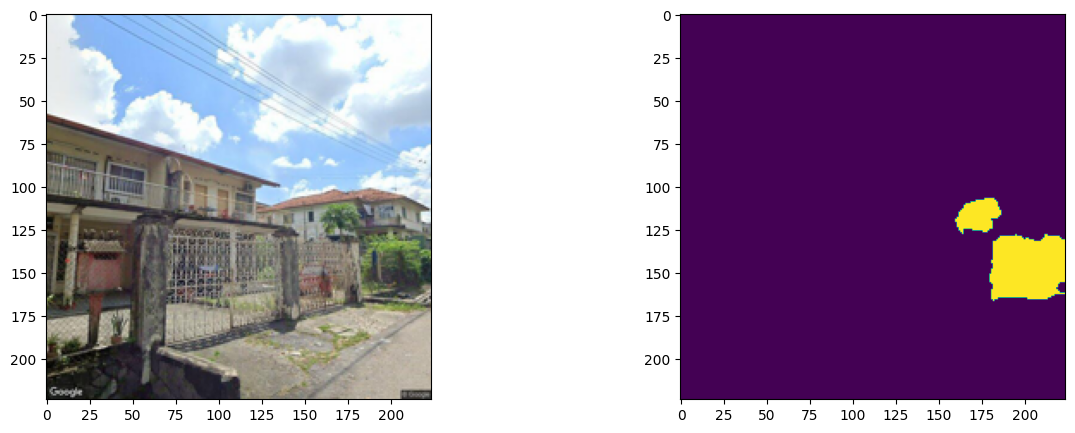

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].imshow(X_train[55])
ax[1].imshow(y_train[55])

In [19]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
#print(X_test.shape, y_test.shape)

(280, 224, 224, 3) (280, 224, 224)
(80, 224, 224, 3) (80, 224, 224)


In [20]:
import os
import pandas as pd

# extract metadata from file name
def save_file_path_in_list(path):
  data = []
  gt = []
  with open(path, 'r') as f:
      content = f.readlines()
  for line in content:
      paths = line.split()
      if len(paths) == 2:
        data.append(paths[0])
        gt.append(paths[1].replace("\n", ""))

  return data, gt

def retrieve_metadata(path):
  
  _, gt = save_file_path_in_list(path)
  
  label_metadata = []
  for file_name in gt:
    # Retrieve the file name
    file_name = os.path.basename(file_name)

    # Remove the file extension
    file_name = os.path.splitext(file_name)[0]
    # Split the file name into its components using the '-' separator
    file_components = file_name.split('-')
    # Extract the latitude, longitude, and heading information from the file name
    lat = (file_components[0])
    lng = (file_components[1])
    heading = int(file_components[2].split('.')[0])

    label_metadata.append([lat, lng, heading])

  return pd.DataFrame(label_metadata, columns=['lat','lng','heading'])

test_metadata = retrieve_metadata('/content/drive/MyDrive/sem2-project_1/images/mask/labelled_pair_test.txt')

In [21]:
test_metadata.head(3)

,lat,lng,heading
0,1.469080304434778,103.7693180467225,60
1,1.469104171408458,103.7625577149652,120
2,1.469124396681811,103.7624672753895,180


# data augmentation

as the allowed `batch_size` is small, and the model converges quickly, data augmentation steps to increase the total amount of data is not useful to further improve the model as the model converges early. 

In [25]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define your data generator with desired augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8,1.2],
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def custom_data_generator(images, labels, batch_size):
    # create two separate generators for the image and label data
    image_gen = datagen.flow(images, batch_size=batch_size, seed=42, shuffle=True) # shuffle to make the weights to get each image the same, seed for reproducibility
    label_gen = datagen.flow(labels, batch_size=batch_size, seed=42, shuffle=True)
    
    # zip the two generators together to get pairs of images and labels
    pair_gen = zip(image_gen, label_gen)
    
    # loop indefinitely and yield batches of augmented pairs
    while True:
        pair_batch = next(pair_gen)
        image_batch = pair_batch[0]
        label_batch = np.mean(pair_batch[1], axis=(1,2))
        
        # ensure the images and labels are of the same shape
        #assert image_batch.shape[:-1] == label_batch.shape
        
        # normalize the label values to be either 0 or 1
        #label_batch = np.where(label_batch > 0.5, 1, 0)
        
        yield (image_batch, label_batch)



In Python, yield and return are used to return values from a function, but they have different behaviors.

return is used to return a value from a function and terminate its execution. When a function returns, it passes control back to the calling function and any state information that was stored in the function's local variables is lost. For example:

python
Copy code
def add(a, b):
    return a + b
yield, on the other hand, is used to create a generator function, which can be used to generate a sequence of values on the fly. When a function yields a value, it does not terminate its execution, but instead suspends it and saves its state so that it can be resumed later. The function can then be resumed from where it left off by calling next() on the generator. For example:"

In [ ]:
# this can be directly inserted into the training model by `step
#train_gen = custom_data_generator(X_train, np.expand_dims(y_train, axis=-1), batch_size=32)
#val_gen = custom_data_generator(X_valid, np.expand_dims(y_valid, axis=-1), batch_size=32)

In [26]:

def generate_augmented_array(n_batches, X, y):
  aug_img = np.zeros((32 * n_batches, 224, 224, 3))
  aug_lbl = np.zeros((32 * n_batches, 1))

  for i in range(n_batches):
      #print(i)
      aug_data = next(custom_data_generator(X, np.expand_dims(y, axis=-1), batch_size=32))
      aug_images, aug_labels = aug_data

      if i == 0:
          aug_img[0:32] = aug_images
          aug_lbl[0:32] = aug_labels
      else:
          aug_img[i * 32:(i + 1) * 32] = aug_images
          aug_lbl[i * 32:(i + 1) * 32] = aug_labels

  print(np.array(aug_img).shape)
  print(np.array(aug_lbl).shape)

  return aug_img, aug_lbl

In [27]:
X_train_aug, y_train_aug = generate_augmented_array(45, X_train, y_train)
np.save("/content/drive/MyDrive/sem2-project_1/images/mask/X_train_DCNN_aug.npy", X_train_aug)
np.save("/content/drive/MyDrive/sem2-project_1/images/mask/y_train_DCNN_aug.npy", y_train_aug)

(1440, 224, 224, 3)
(1440, 1)


In [28]:
X_train_aug = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/X_train_DCNN_aug.npy")
y_train_aug_GVI = np.load("/content/drive/MyDrive/sem2-project_1/images/mask/y_train_DCNN_aug.npy")

In [ ]:
y_train_aug_GVI.shape

(1440, 1)

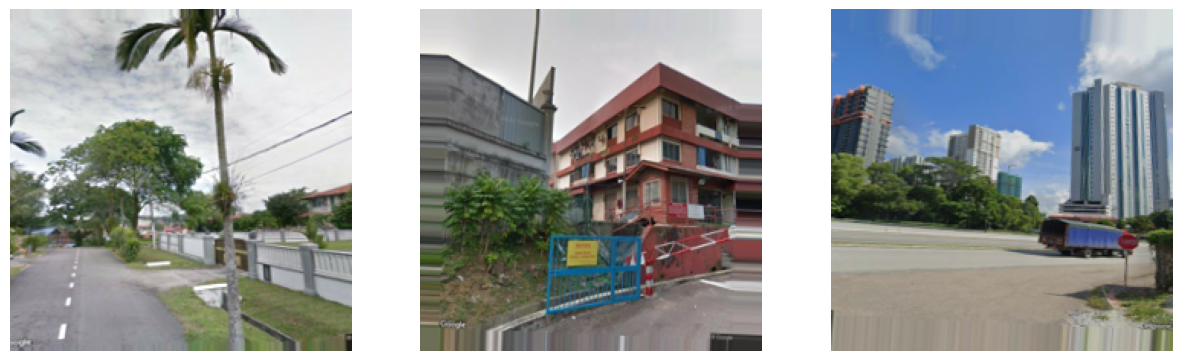

In [ ]:
f, ax = plt.subplots(1,3, figsize = (15,5))

for i,j in zip(range(3), [3,6,15]):
  ax[i].imshow(X_train_aug[j])
  ax[i].axis('off')

In [ ]:
y_train_aug[15]

array([0.1270109])

# hyperparameter tuning

In [ ]:
from tensorflow.keras import metrics

class MyHyperModel(kt.HyperModel):
    def build_DCNN_model(self, hp):
      DCNN_model = tf.keras.models.load_model("/content/drive/MyDrive/sem2-project_1/treepedia_dl_public-master/weights_test.hdf5")
      # Freeze all layers except for the last 5
      for layer in DCNN_model.layers[:-5]:
          layer.trainable = False
        
      
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      DCNN_model.compile(loss='binary_crossentropy', 
                        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                        metrics=[metrics.MeanAbsoluteError()])
      
      return DCNN_model

    def fit(self, hp, DCNN_model, *args, **kwargs):
        return DCNN_model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )


In [ ]:
#!pip install -q -U keras-tuner
#import keras_tuner as kt

In [ ]:
#import tensorflow as tf
#DCNN_model = tf.keras.models.load_model("/content/drive/MyDrive/sem2-project_1/treepedia_dl_public-master/weights_test.hdf5")
#DCNN_model.summary()

In [ ]:
from tensorflow.keras import metrics
import tensorflow as tf
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):    # this method can only be named `build`, cannot be changed
        DCNN_model = tf.keras.models.load_model("/content/drive/MyDrive/sem2-project_1/treepedia_dl_public-master/weights_test.hdf5")
        # Freeze all layers except for the last 5
        for layer in DCNN_model.layers[:-5]:
            layer.trainable = False

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        DCNN_model.compile(loss='binary_crossentropy', 
                           optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                           metrics=[metrics.MeanAbsoluteError()])

        return DCNN_model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_mean_absolute_error',
    max_trials=10,
    executions_per_trial=2,
    project_name='my_project'
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                min_delta=0.0001,
                patience=20,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True)

#tuner.search(X_train, y_train_GVI, epochs=3, validation_data=(X_valid, y_valid_GVI), callbacks=[early_stopping])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]
#best_hps

Trial 5 Complete [00h 06m 22s]
val_mean_absolute_error: 0.04376990906894207

Best val_mean_absolute_error So Far: 0.04282737895846367
Total elapsed time: 00h 19m 36s


In [ ]:
#print(best_hps.get('batch_size'), best_hps.get('learning_rate'))

32 0.001


In [ ]:
# Build the model with the best hyperparameters
# in our case to plot the hhistory (epoch to convergence), this is not used as it will use the pretrained weights from `tuner`
#my_model = MyHyperModel()
#DCNN_model = my_model.build(best_hps)
#DCNN_model

# fine-tune model

In [22]:
from tensorflow.keras import metrics
import tensorflow as tf

def build_DCNN():    # this method can only be named `build`, cannot be changed
  DCNN_model = tf.keras.models.load_model("/content/drive/MyDrive/sem2-project_1/treepedia_dl_public-master/weights_test.hdf5")
  # Freeze all layers except for the last 5
  for layer in DCNN_model.layers[:-5]:
      layer.trainable = False

  hp_learning_rate = 0.001

  DCNN_model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                      metrics=[metrics.MeanAbsoluteError()])

  return DCNN_model

early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                min_delta=0.0001,
                patience=20,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True)

DCNN_model = build_DCNN()
import time
st =  time.time()

history = DCNN_model.fit(X_train, y_train_GVI, epochs=100, batch_size=32,
                       validation_data=(X_valid, y_valid_GVI), 
                       callbacks=[early_stopping])


et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

Epoch 1/100
9/9 [==============================] - 19s 549ms/step - loss: 0.4956 - mean_absolute_error: 0.1014 - val_loss: 0.4629 - val_mean_absolute_error: 0.0858
Epoch 2/100
9/9 [==============================] - 1s 135ms/step - loss: 0.4733 - mean_absolute_error: 0.0730 - val_loss: 0.4548 - val_mean_absolute_error: 0.0740
Epoch 3/100
9/9 [==============================] - 1s 143ms/step - loss: 0.4684 - mean_absolute_error: 0.0644 - val_loss: 0.4539 - val_mean_absolute_error: 0.0661
Epoch 4/100
9/9 [==============================] - 1s 127ms/step - loss: 0.4658 - mean_absolute_error: 0.0615 - val_loss: 0.4559 - val_mean_absolute_error: 0.0663
Epoch 5/100
9/9 [==============================] - 1s 116ms/step - loss: 0.4643 - mean_absolute_error: 0.0594 - val_loss: 0.4604 - val_mean_absolute_error: 0.0691
Epoch 6/100
9/9 [==============================] - 1s 144ms/step - loss: 0.4661 - mean_absolute_error: 0.0615 - val_loss: 0.4572 - val_mean_absolute_error: 0.0650
Epoch 7/100
9/9 [====

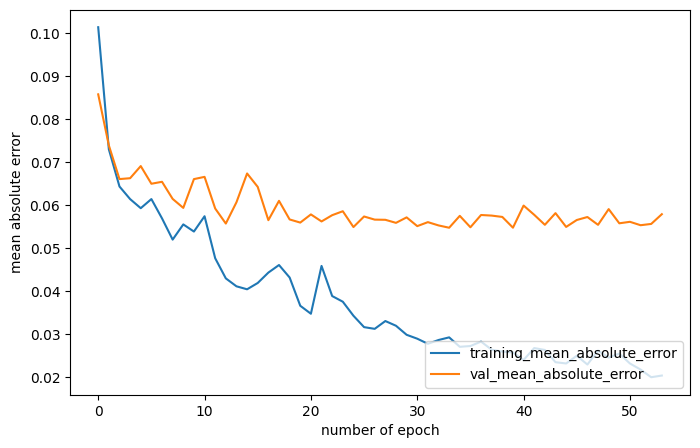

In [23]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(history.history['mean_absolute_error'])
ax.plot(history.history['val_mean_absolute_error'])

plt.legend(["training_mean_absolute_error", "val_mean_absolute_error"], loc ="lower right")
plt.xlabel('number of epoch')
plt.ylabel('mean absolute error')

plt.show()

In [29]:
import time

DCNN_model_aug = build_DCNN()

st =  time.time()
history_aug = DCNN_model_aug.fit((X_train_aug * 255), y_train_aug_GVI, epochs=100, batch_size=32,
                       validation_data=(X_valid, y_valid_GVI), 
                       callbacks=[early_stopping])


et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

Epoch 1/100
45/45 [==============================] - 12s 133ms/step - loss: 0.4557 - mean_absolute_error: 0.0771 - val_loss: 0.4633 - val_mean_absolute_error: 0.0874
Epoch 2/100
45/45 [==============================] - 5s 103ms/step - loss: 0.4335 - mean_absolute_error: 0.0471 - val_loss: 0.4554 - val_mean_absolute_error: 0.0709
Epoch 3/100
45/45 [==============================] - 5s 120ms/step - loss: 0.4227 - mean_absolute_error: 0.0187 - val_loss: 0.4543 - val_mean_absolute_error: 0.0675
Epoch 4/100
45/45 [==============================] - 5s 104ms/step - loss: 0.4201 - mean_absolute_error: 0.0071 - val_loss: 0.4545 - val_mean_absolute_error: 0.0684
Epoch 5/100
45/45 [==============================] - 4s 99ms/step - loss: 0.4196 - mean_absolute_error: 0.0031 - val_loss: 0.4543 - val_mean_absolute_error: 0.0679
Epoch 6/100
45/45 [==============================] - 5s 103ms/step - loss: 0.4194 - mean_absolute_error: 0.0014 - val_loss: 0.4542 - val_mean_absolute_error: 0.0679
Epoch 7/10

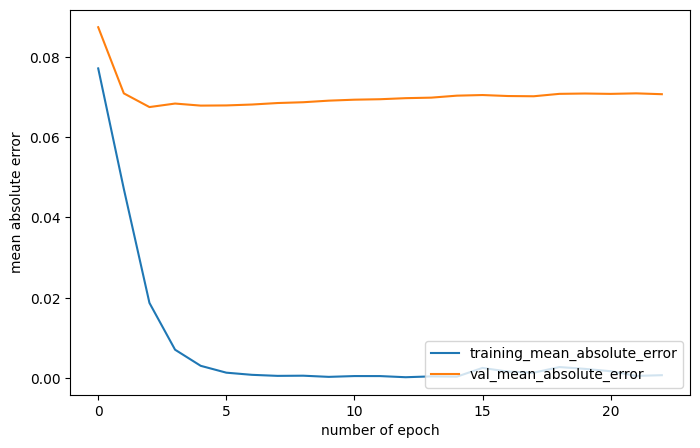

In [30]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(history_aug.history['mean_absolute_error'])
ax.plot(history_aug.history['val_mean_absolute_error'])

plt.legend(["training_mean_absolute_error", "val_mean_absolute_error"], loc ="lower right")
plt.xlabel('number of epoch')
plt.ylabel('mean absolute error')

plt.show()

In [24]:
DCNN_model.save("/content/drive/MyDrive/sem2-project_1/DCNN_model2.hdf5")

# Inference

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/sem2-project_1/DCNN_model.hdf5')

In [ ]:
import time
st =  time.time()

pred_ts = model.predict(X_test, batch_size=8)
pred_ts.shape

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

10/10 [==============================] - 1s 35ms/step
training time =  1.7436158657073975 seconds


In [ ]:
# compute difference between prediction and true GVI
diff = np.zeros([len(X_test), 1])
for i in range(len(X_test)):
    diff[i] = y_test_GVI[i]-pred_ts[i]

# evaluate accuracy of model
print("Average Absolute GVI error is: %f" % np.mean(np.abs(diff)))
percentile_result = np.percentile(diff, [5, 95])
print("5-95 percentile of Absolute GVI error is (%f, %f)" %
      (percentile_result[0], percentile_result[1]))
print("Correlation of predicted and true GVI is: %f" %
      np.corrcoef(pred_ts.T, y_test_GVI.T)[0, 1])

Average Absolute GVI error is: 0.040711
5-95 percentile of Absolute GVI error is (-0.091110, 0.070884)
Correlation of predicted and true GVI is: 0.973489


In [ ]:
(DCNN_prediction['gt'] - DCNN_prediction['pred']).abs()

0     0.000145
1     0.053301
2     0.009971
3     0.067299
4     0.036252
        ...   
75    0.009500
76    0.063740
77    0.079162
78    0.052346
79    0.070560
Length: 80, dtype: float64

In [ ]:
DCNN_prediction = pd.concat([test_metadata, pd.Series(pred_ts.flatten()), pd.Series(y_test_GVI)], 
                            axis=1)
DCNN_prediction = DCNN_prediction.rename(columns={0: 'pred', 1: 'gt'})
DCNN_prediction['diff'] = (DCNN_prediction['gt'] - DCNN_prediction['pred']).abs()
DCNN_prediction

,lat,lng,heading,pred,gt,diff
0,1.469080304434778,103.7693180467225,60,0.620172,0.620316,0.000145
1,1.469104171408458,103.7625577149652,120,0.168974,0.115673,0.053301
2,1.469124396681811,103.7624672753895,180,0.216704,0.206732,0.009971
3,1.46913486437251,103.7690494552515,240,0.776203,0.708905,0.067299
4,1.469136362943726,103.768296818482,60,0.139369,0.103117,0.036252
...,...,...,...,...,...,...
75,1.4724813169454,103.7624548101155,0,0.009500,0.000000,0.009500
76,1.4724813169454,103.7624548101155,180,0.156514,0.092773,0.063740
77,1.472533700093861,103.7643465391866,180,0.104573,0.025411,0.079162
78,1.472662343862685,103.762351463314,240,0.171785,0.224131,0.052346


In [ ]:
#DCNN_prediction.to_csv("/content/drive/MyDrive/sem2-project_1/DCNN_prediction_df.csv")